In [1]:
import cv2
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from glob import glob
import numpy as np
from utils import *

# Camera Calibration

In [10]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

image_names = glob("camera_cal/*")

for img_name in image_names:
    image = cv2.imread(img_name)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,(9,6), None)
    
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # img = cv2.drawChessboardCorners(u_img, (9,6), corners, ret)
        # cv2.imshow('img', img)
        # cv2.waitKey(500)
        

In [11]:
test_images = glob("test_images/*")
images = []
for image in test_images:
    images.append((image, mpimg.imread(image)))
    
def show_images(images, cmap=None):
    f, axes = plt.subplots(len(images)//2, 2, figsize=(15,12))
    indexes = range(len(images) * 2)
    for ax, index in zip(axes.flat, indexes):
        if index < len(images):
            path, image = images[index]
            ax.imshow(image, cmap=cmap)
            ax.set_title(path.split('\\')[1])
            ax.axis('off')

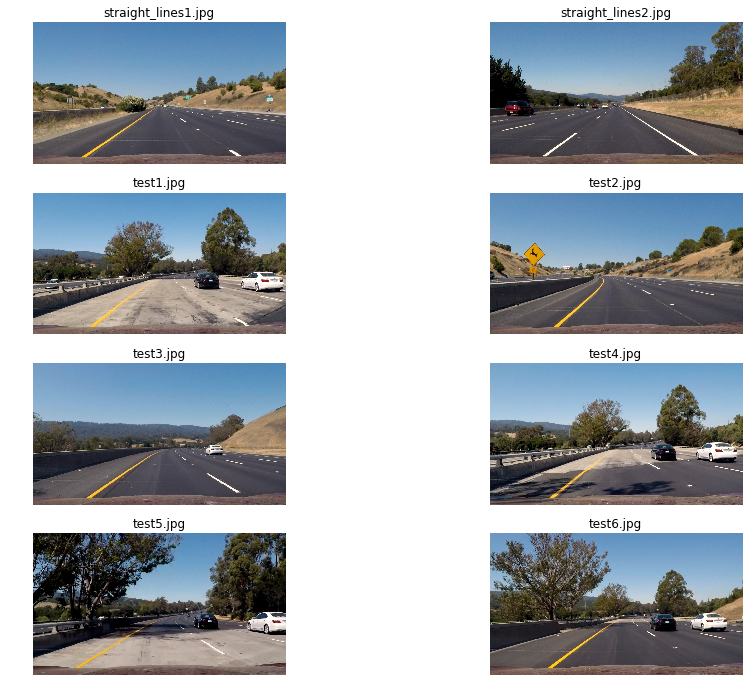

In [12]:
show_images(images)

# Distortion Correction

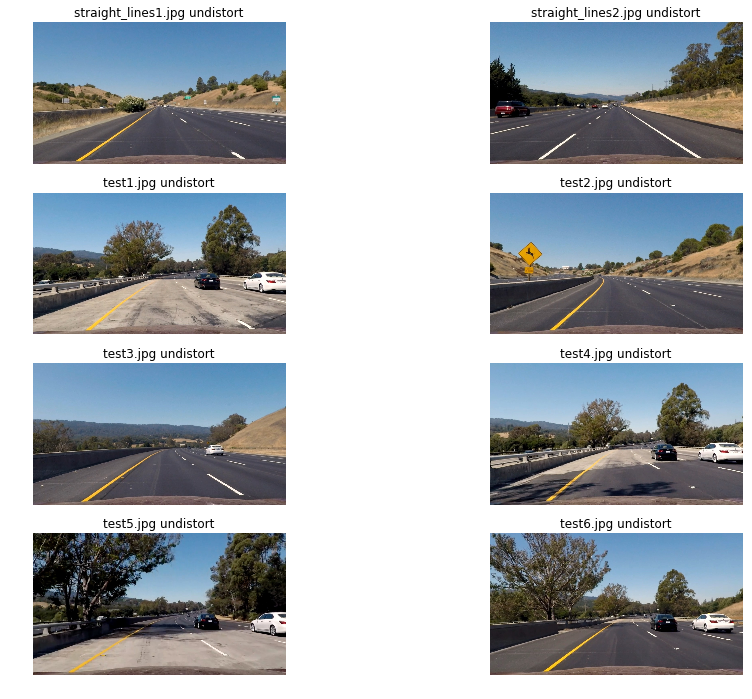

In [13]:
udist_images = []
for item in images:  
    path, image = item
    u_img, mtx, dist = undistort_img(image, objpoints, imgpoints)
    udist_images.append([path+" undistort",u_img])
    
show_images(udist_images)



# gradient and color thresholds

In [14]:
def pipeline(img):
    binary_sobel = abs_sobel_thres(img, orient='x', kernel=3, threshold=(30, 100))
    binary_mg = mag_gradient(img, threshold=(70, 100))
    binary_dir = dir_gradient(img, threshold=(0.8, 1.3))
    binary_c = color_threshold(img, threshold=(160, 254))
    binary_g = gray_threshold(img)
    binary_out = np.zeros_like(binary_dir)
    binary_out[((binary_g == 1)|(binary_c == 1)|(binary_sobel==1))] = 1
    return binary_out


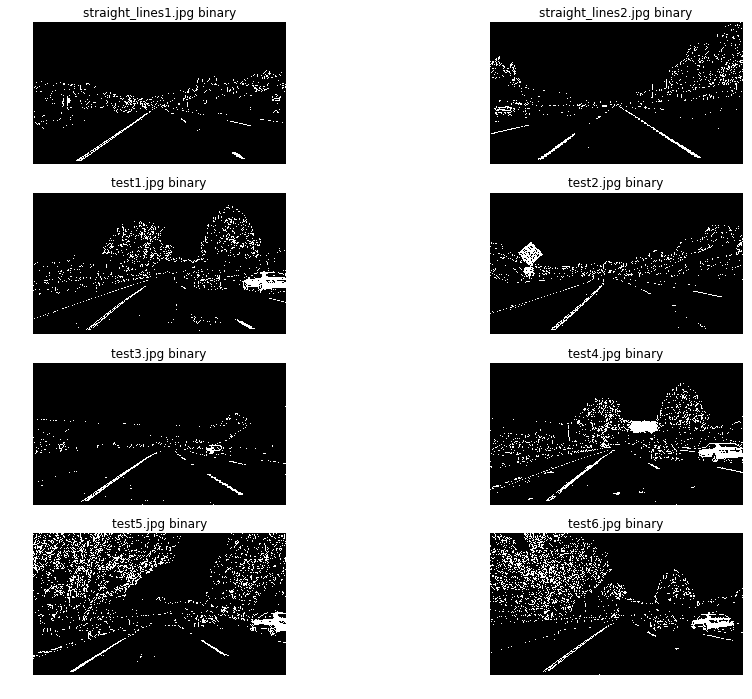

In [15]:
binary_images = []
for item in udist_images:
    path, u_img = item
    binary_out = pipeline(u_img)
    binary_images.append([path.split()[0]+" binary",binary_out])
    
show_images(binary_images, cmap="gray")

# Perspective Transform (Birds-eye view)

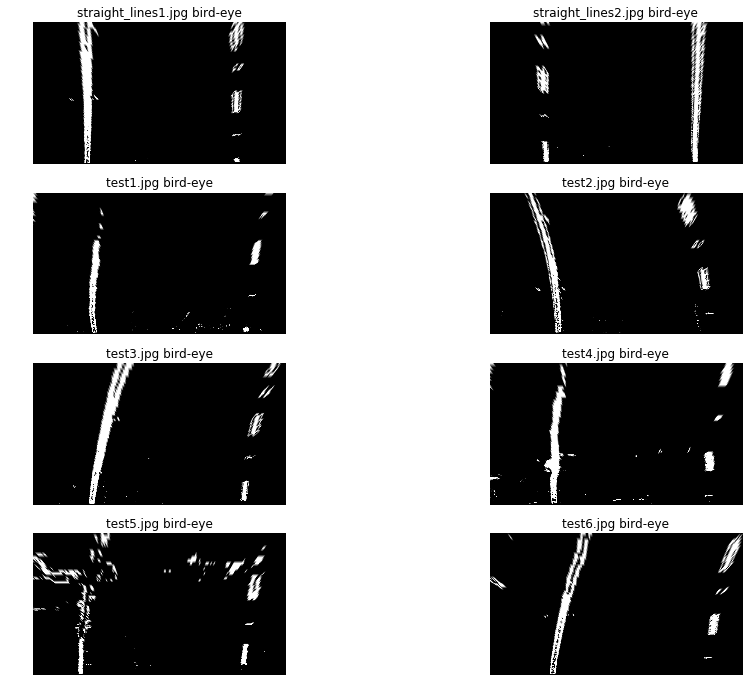

In [16]:
warped_images = []
warped_M_Minv = []
for item in binary_images:
    path, u_img = item
    warp_img, M, Minv = warp_corners(u_img)
    warped_M_Minv.append([M, Minv])
    warped_images.append([path.split()[0]+" bird-eye", warp_img])
    
show_images(warped_images, cmap="gray")


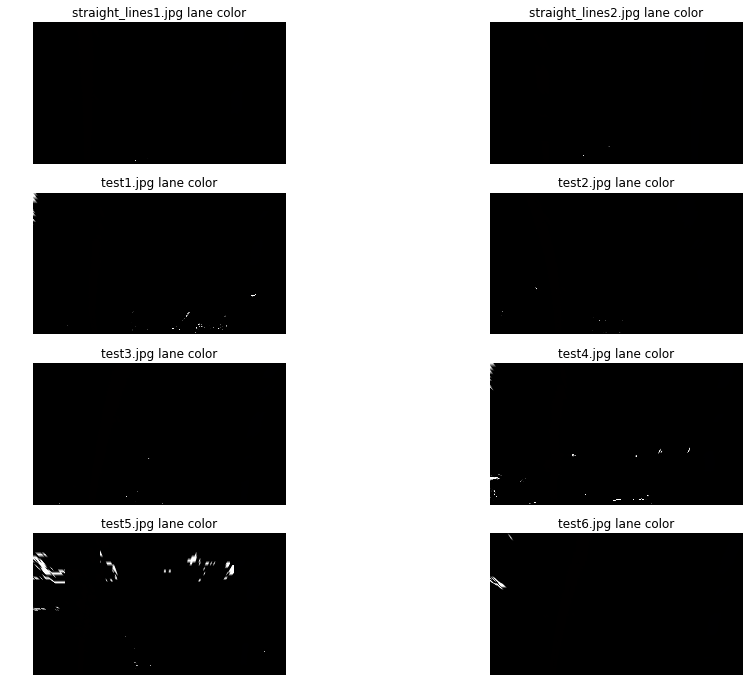

In [17]:
lanes = []
lanes_details = []
for item in warped_images:
    path, warp_img = item
    left_fit, right_fit, left_fit_m, right_fit_m, out_img  = find_lanes(warp_img)
    lanes_details.append([left_fit, right_fit, left_fit_m, right_fit_m])
    lanes.append([path.split()[0] + " lane color", out_img])
show_images(lanes)

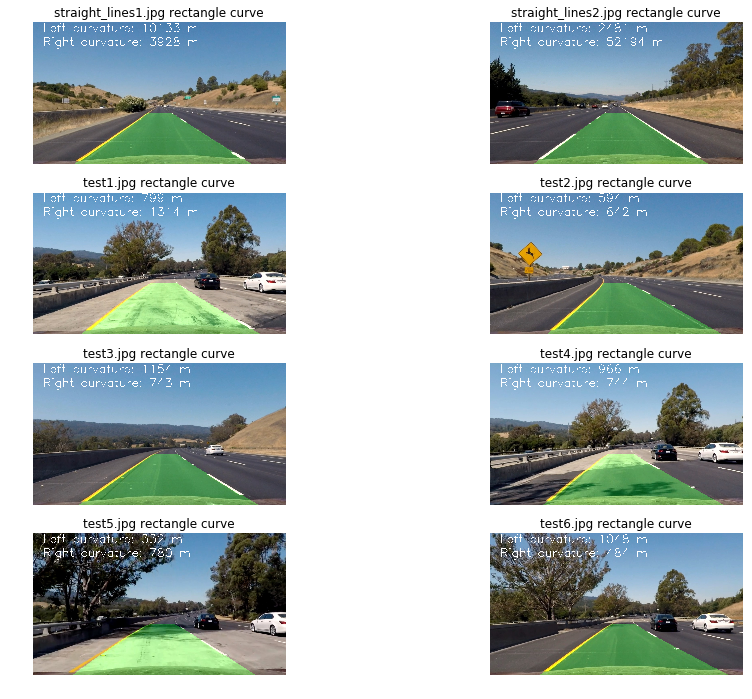

In [18]:
results = []
for i in range(len(lanes)):
    _, u_img = udist_images[i]
    path, warp_img = warped_images[i]
    left_fit, right_fit, left_fit_m, right_fit_m  = lanes_details[i]
    M, Minv = warped_M_Minv[i]
    
    result = draw_rectangle(u_img, warp_img, Minv, left_fit, right_fit)
    left_curv, right_curv = calculateCurvature(719,left_fit_m, right_fit_m)

    result = drawCurvature(result, left_curv, right_curv)
    results.append((path.split()[0]+" rectangle curve", result))
show_images(results)

In [20]:
def process_image(image):
    u_img, mtx, dist = undistort_img(image, objpoints, imgpoints)
    binary_out = pipeline(u_img)
    warped, M, Minv = warp_corners(binary_out) 
    left_fit, right_fit, left_fit_m, right_fit_m, out_img = find_lanes(warped)
    final = draw_rectangle(u_img, warped, Minv, left_fit, right_fit)
    return final

In [23]:
img = process_image(images[2])
plt.imshow(img)

AttributeError: 'tuple' object has no attribute 'shape'

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video solidWhiteRight.mp4.
MoviePy - Writing audio in solidWhiteRightTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video solidWhiteRight.mp4



TypeError: must be real number, not NoneType